# Human Activity Recognition using Support Vector Machines

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import ex2_helper as helper
import pandas as pd

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

### Load and preprocess the HAR data: Human Activity Recognition Using Smartphones Dataset

In [2]:
X_train, X_test, y_train, y_test = helper.separate_subjects(*helper.load_data())

### Convert the original 6-class labels into a binary (active vs. inactive) problem.

In [3]:
y_train = y_train.apply(helper.to_binary_label)
y_test = y_test.apply(helper.to_binary_label)

The data in y_train is imbalanced, as 0 -> 4067 and 1 -> 3285 samples

### Train baseline SVM models with different kernels (linear, polynomial, RBF).

In [4]:
pipe = Pipeline([
('scaler', StandardScaler()), 
('pca', PCA(n_components= 50)),
('svc', SVC(class_weight='balanced'))
])

param_grid = [
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10, 100]
    },
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1, 10, 100],
        'svc__degree': [2, 3],
        'svc__gamma': [0.001, 0.01, 0.1]
    },
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': [0.001, 0.01, 0.1]
    },{
        'svc__kernel': ['sigmoid'],
        'svc__gamma': [0.001, 0.01, 0.1]
    },
]

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)
print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

f1_best = metrics.f1_score(y_test, y_pred, average=None)
cm_best = metrics.confusion_matrix(y_test, y_pred)
print("Test set evaluation for the best model:")
print("F1 Score:", f1_best)
print("Confusion Matrix:")
print(cm_best)

Fitting 3 folds for each of 43 candidates, totalling 129 fits
Best parameters from GridSearchCV: {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best cross-validation F1 score: 0.9990507726785433
Test set evaluation for the best model:
F1 Score: [1. 1.]
Confusion Matrix:
[[1165    0]
 [   0  985]]


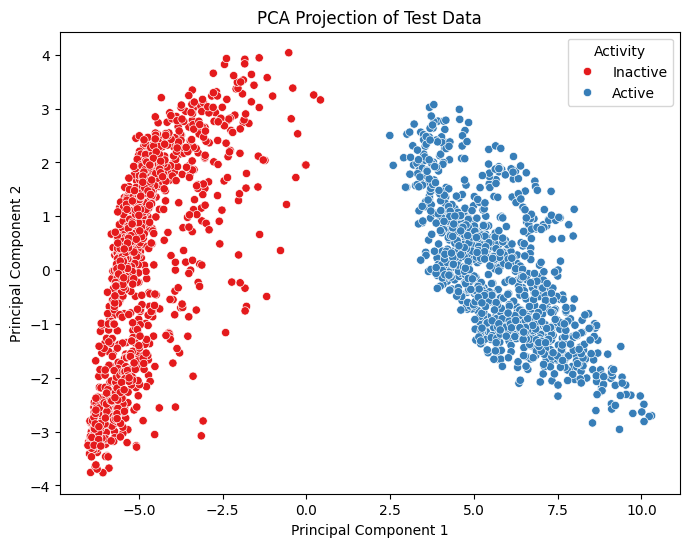

In [5]:
# Reduce the test data to 2 dimensions (for visualization)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], 
                hue=y_test.map({0: "Inactive", 1: "Active"}),
                palette="Set1")
plt.title("PCA Projection of Test Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Activity")
plt.show()


In [6]:
# Convert the CV results to a DataFrame for easy filtering
cv_results = pd.DataFrame(grid_search.cv_results_)

# Iterate over each kernel type and find the best configuration
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    kernel_results = cv_results[cv_results['param_svc__kernel'] == kernel]

    best_idx = kernel_results['mean_test_score'].idxmax()
    best_params = cv_results.loc[best_idx, 'params']
    best_score = cv_results.loc[best_idx, 'mean_test_score']
    best_time = cv_results.loc[best_idx, 'mean_fit_time']

    print(f"Best configuration for kernel '{kernel}':")
    print(f"  Parameters: {best_params}")
    print(f"  Mean CV F1 Score: {best_score:.4f}")
    print(f"  Mean CV time: {best_time:.4f}\n")


Best configuration for kernel 'linear':
  Parameters: {'svc__C': 1, 'svc__kernel': 'linear'}
  Mean CV F1 Score: 0.9989
  Mean CV time: 0.3093

Best configuration for kernel 'poly':
  Parameters: {'svc__C': 1, 'svc__degree': 3, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}
  Mean CV F1 Score: 0.9989
  Mean CV time: 0.3098

Best configuration for kernel 'rbf':
  Parameters: {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
  Mean CV F1 Score: 0.9991
  Mean CV time: 0.3100

Best configuration for kernel 'sigmoid':
  Parameters: {'svc__gamma': 0.001, 'svc__kernel': 'sigmoid'}
  Mean CV F1 Score: 0.9989
  Mean CV time: 0.2662



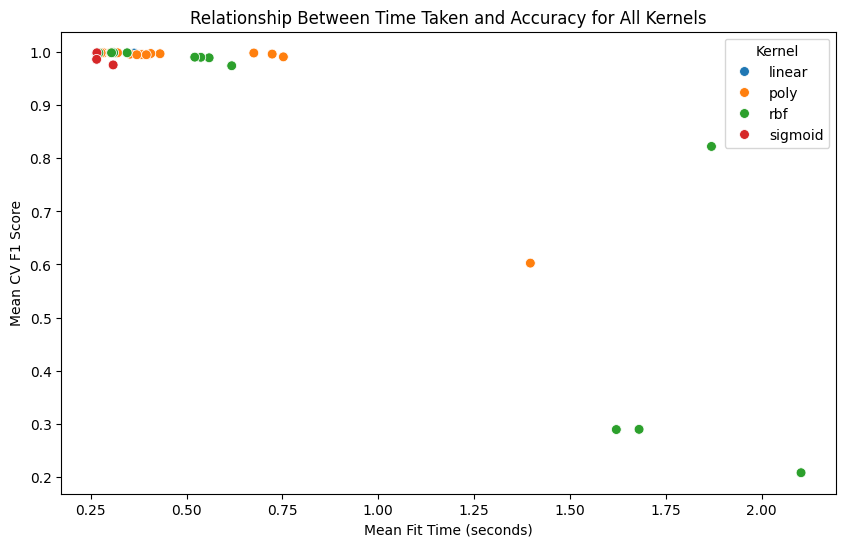

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=cv_results, 
    x='mean_fit_time', 
    y='mean_test_score', 
    hue='param_svc__kernel',
    s=50
)
plt.title("Relationship Between Time Taken and Accuracy for All Kernels")
plt.xlabel("Mean Fit Time (seconds)")
plt.ylabel("Mean CV F1 Score")
plt.legend(title="Kernel")
plt.show()
